# Airglow data-driven modeling over a period of three solar cycles

## Authors
Š. Mackovjak (1, 3), M. Varga (2), S. Hrivňak (3), O. Palkoci (3),  G. G. Didebulidze (4)



1.   Department of Space Physics, Institute of Experimental Physics, Slovak Academy of Sciences, Košice, Slovakia
2.   Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia
3.   GlobalLogic s.r.o., Košice, Slovakia
4. Georgian National Astrophysical Observatory, Ilia State University, Tbilisi, Georgia

## Contact
All questions and comments related to this work can be addresed to:
Simon Mackovjak, Institute of Experimental Physics, Slovak Academy of Sciences, Watsonova 47, 04001 Košice, Slovakia, mackovjak(at)saske.sk


## Abstract
The Earth’s upper atmosphere is a dynamic environment that is continuously affected by space weather from above and atmospheric processes from below. An effective way to observe this interface region is the monitoring of airglow.  Since the 1950s, airglow emissions have been systematically measured by ground-based photometers in specific wavelength bands during the nighttime. The availability of the calibrated data from over 30 years of photometric airglow measurements from Georgia, at wavelengths of 557.7 nm and 630.0 nm, enable us to investigate if a data-driven model based on advanced machine learning techniques can be successfully employed for modeling airglow intensities. A regression task was performed using the time series of space weather indices and thermosphere-ionosphere parameters. We have found that the developed data-driven model has good consistency with the commonly used airglow model and also captures airglow variations caused by cycles of solar activity and changes of the seasons. This enables us to visualize the green and red airglow variations over a period of three solar cycles with a one-hour time resolution.

## Python notebook
In the following, we present the data and Python methods used for analysis presented in the article. They can be used to reprodece and verify the obtained results. Here is an overview of the python notebook:
1. Data introduction
2. Machine Learning techniques
  * 2.1 Linear regression
  * 2.2 Neural network
  * 2.3 Random Forest
  * 2.4 XGBoost
3. Verification of data-driven model
  * 3.1 Simulated intensities by XGBoost and GLOW models
  * 3.2 Vizualization of modeled airglow variations


# 1. Data introduction

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import datetime
import math
from scipy import stats
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

In [2]:
# set the plotting style and precision of displayed values
plt.style.use('default')
plt.style.use('seaborn-deep')
pd.set_option("display.precision", 2)

In [3]:
# The source and description of the data is listed in Table 1 of the article.

# read the data stored in pkl file and print basic characteristics. 
# 'mdf' stands for 'Main Data Frame'
# 'g' stands for 'green airglow line' with wvl 557.7 nm, thermosphere-ionosphere data are for altitude 95 km
# 'r' stands for 'red airglow line' with wvl 630.0 nm, thermosphere-ionosphere data are for altitude 250 km
mdfg = pd.read_pickle('https://github.com/space-lab-sk/space-lab-sk.github.io/raw/master/papers/mackovjak_2021/df_i5577_label_features_1964-1993.pkl')
mdfr = pd.read_pickle('https://github.com/space-lab-sk/space-lab-sk.github.io/raw/master/papers/mackovjak_2021/df_i6300_label_features_1964-1993.pkl')
print(f'The list of column names: {list(mdfg)}')
print(f'\nThe number of rows and columns of the data frame: {mdfg.shape}')
print('\nThe head and tail of the green airglow line data frame:')
mdfg

The list of column names: ['I5577', 'F107_SFU', 'Kp_10', 'Dst_nT', 'NeutralTemp_K', 'NeutralDens_g/cm3', 'O_cm-3', 'O2_cm-3', 'N_cm-3', 'N2_cm-3', 'H_cm-3', 'SunEarth_AU', 'ne_m-3', 'Te_K', 'hmF2_km', 'NmF2_m-3']

The number of rows and columns of the data frame: (46222, 16)

The head and tail of the green airglow line data frame:


,I5577,F107_SFU,Kp_10,Dst_nT,NeutralTemp_K,NeutralDens_g/cm3,O_cm-3,O2_cm-3,N_cm-3,N2_cm-3,H_cm-3,SunEarth_AU,ne_m-3,Te_K,hmF2_km,NmF2_m-3
1964-01-01 16:00:00,NaN,NaN,20.0,16.0,176.77,1.28e-09,4.98e+11,5.32e+12,132566.67,2.08e+13,4.52e+07,0.98,1.47e+09,178.23,323.30,1.18e+11
1964-01-02 16:00:00,NaN,68.3,47.0,-57.0,176.70,1.28e-09,4.97e+11,5.32e+12,131566.67,2.08e+13,4.26e+07,0.98,1.47e+09,176.43,323.60,1.30e+11
1964-01-02 17:00:00,NaN,68.3,47.0,-55.0,176.74,1.28e-09,4.98e+11,5.33e+12,131620.83,2.08e+13,4.24e+07,0.98,1.47e+09,176.33,323.61,1.31e+11
1964-01-03 16:00:00,NaN,70.7,37.0,-22.0,177.07,1.31e-09,5.10e+11,5.43e+12,132333.33,2.12e+13,4.13e+07,0.98,1.47e+09,175.80,323.83,1.31e+11
1964-01-03 17:00:00,NaN,70.7,37.0,-25.0,177.07,1.31e-09,5.10e+11,5.43e+12,132354.17,2.13e+13,4.13e+07,0.98,1.47e+09,175.81,323.84,1.31e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993-12-24 01:00:00,NaN,107.5,27.0,-1.0,177.40,1.33e-09,5.58e+11,5.37e+12,142400.00,2.19e+13,3.89e+07,0.98,1.62e+09,176.80,306.38,1.23e+11
1993-12-24 02:00:00,NaN,107.5,27.0,2.0,177.40,1.33e-09,5.58e+11,5.37e+12,142400.00,2.19e+13,3.89e+07,0.98,1.62e+09,176.81,306.35,1.23e+11
1993-12-25 01:00:00,NaN,115.2,20.0,-13.0,177.41,1.34e-09,5.61e+11,5.39e+12,142416.67,2.20e+13,3.86e+07,0.98,1.62e+09,176.90,305.77,1.24e+11
1993-12-25 02:00:00,NaN,115.2,20.0,-13.0,177.42,1.34e-09,5.61e+11,5.39e+12,142433.33,2.20e+13,3.86e+07,0.98,1.62e+09,176.91,305.74,1.24e+11


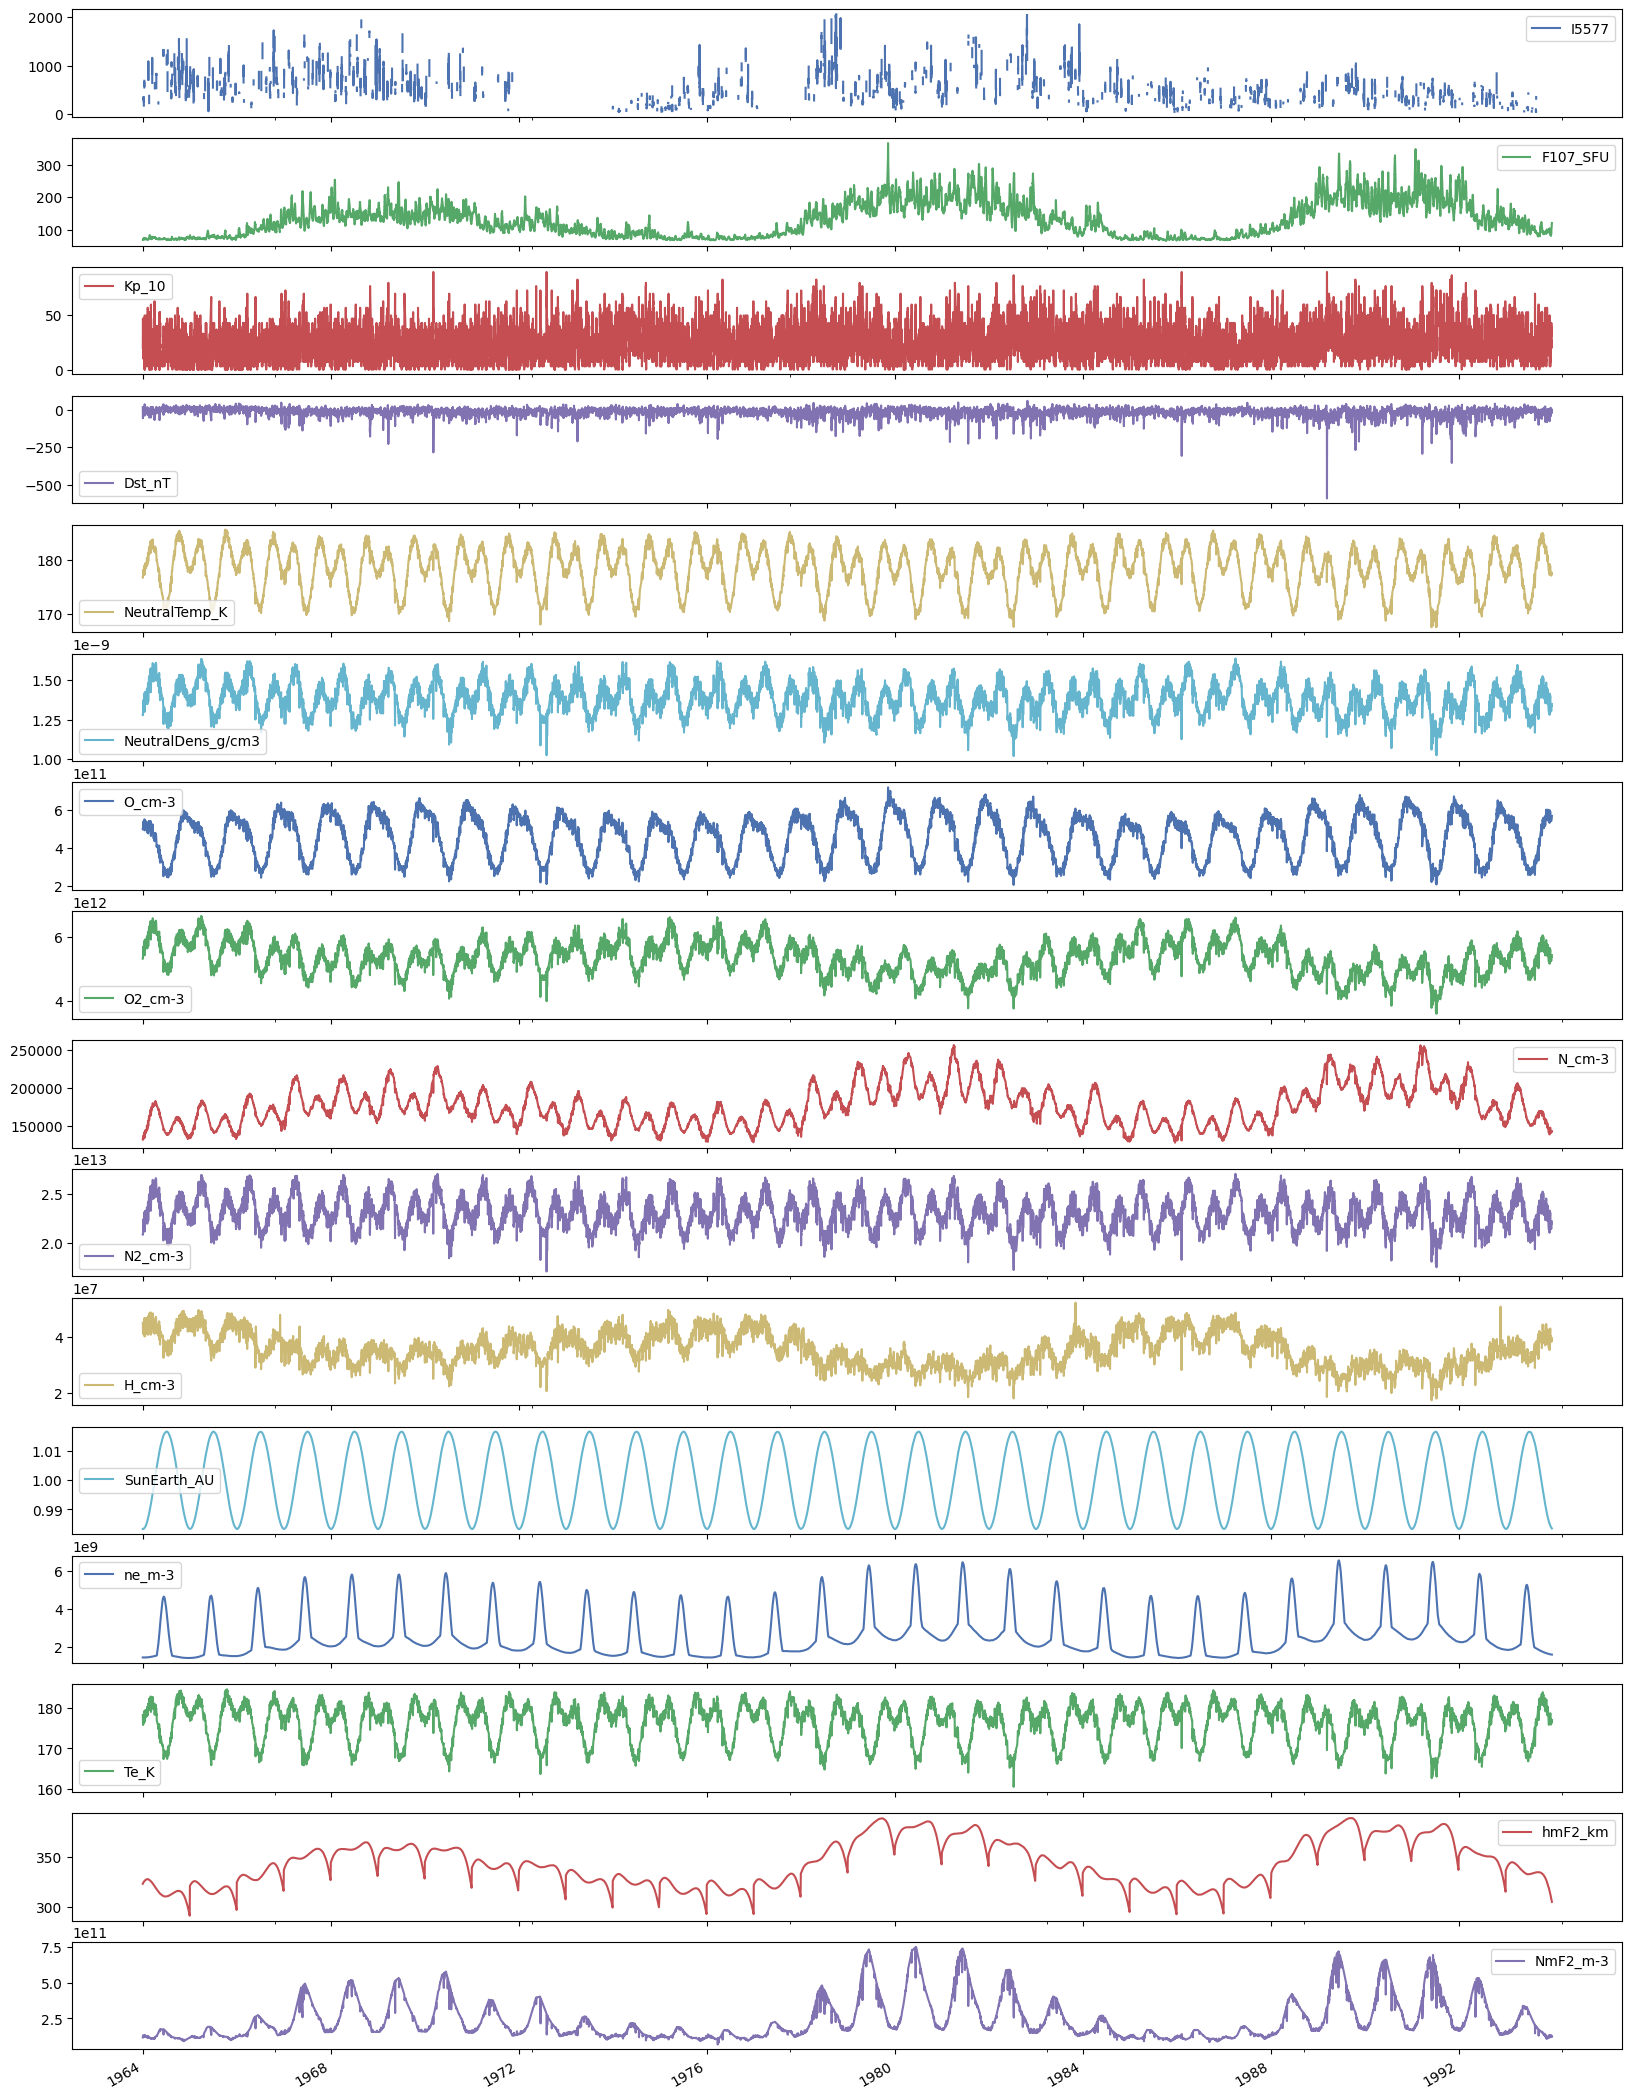

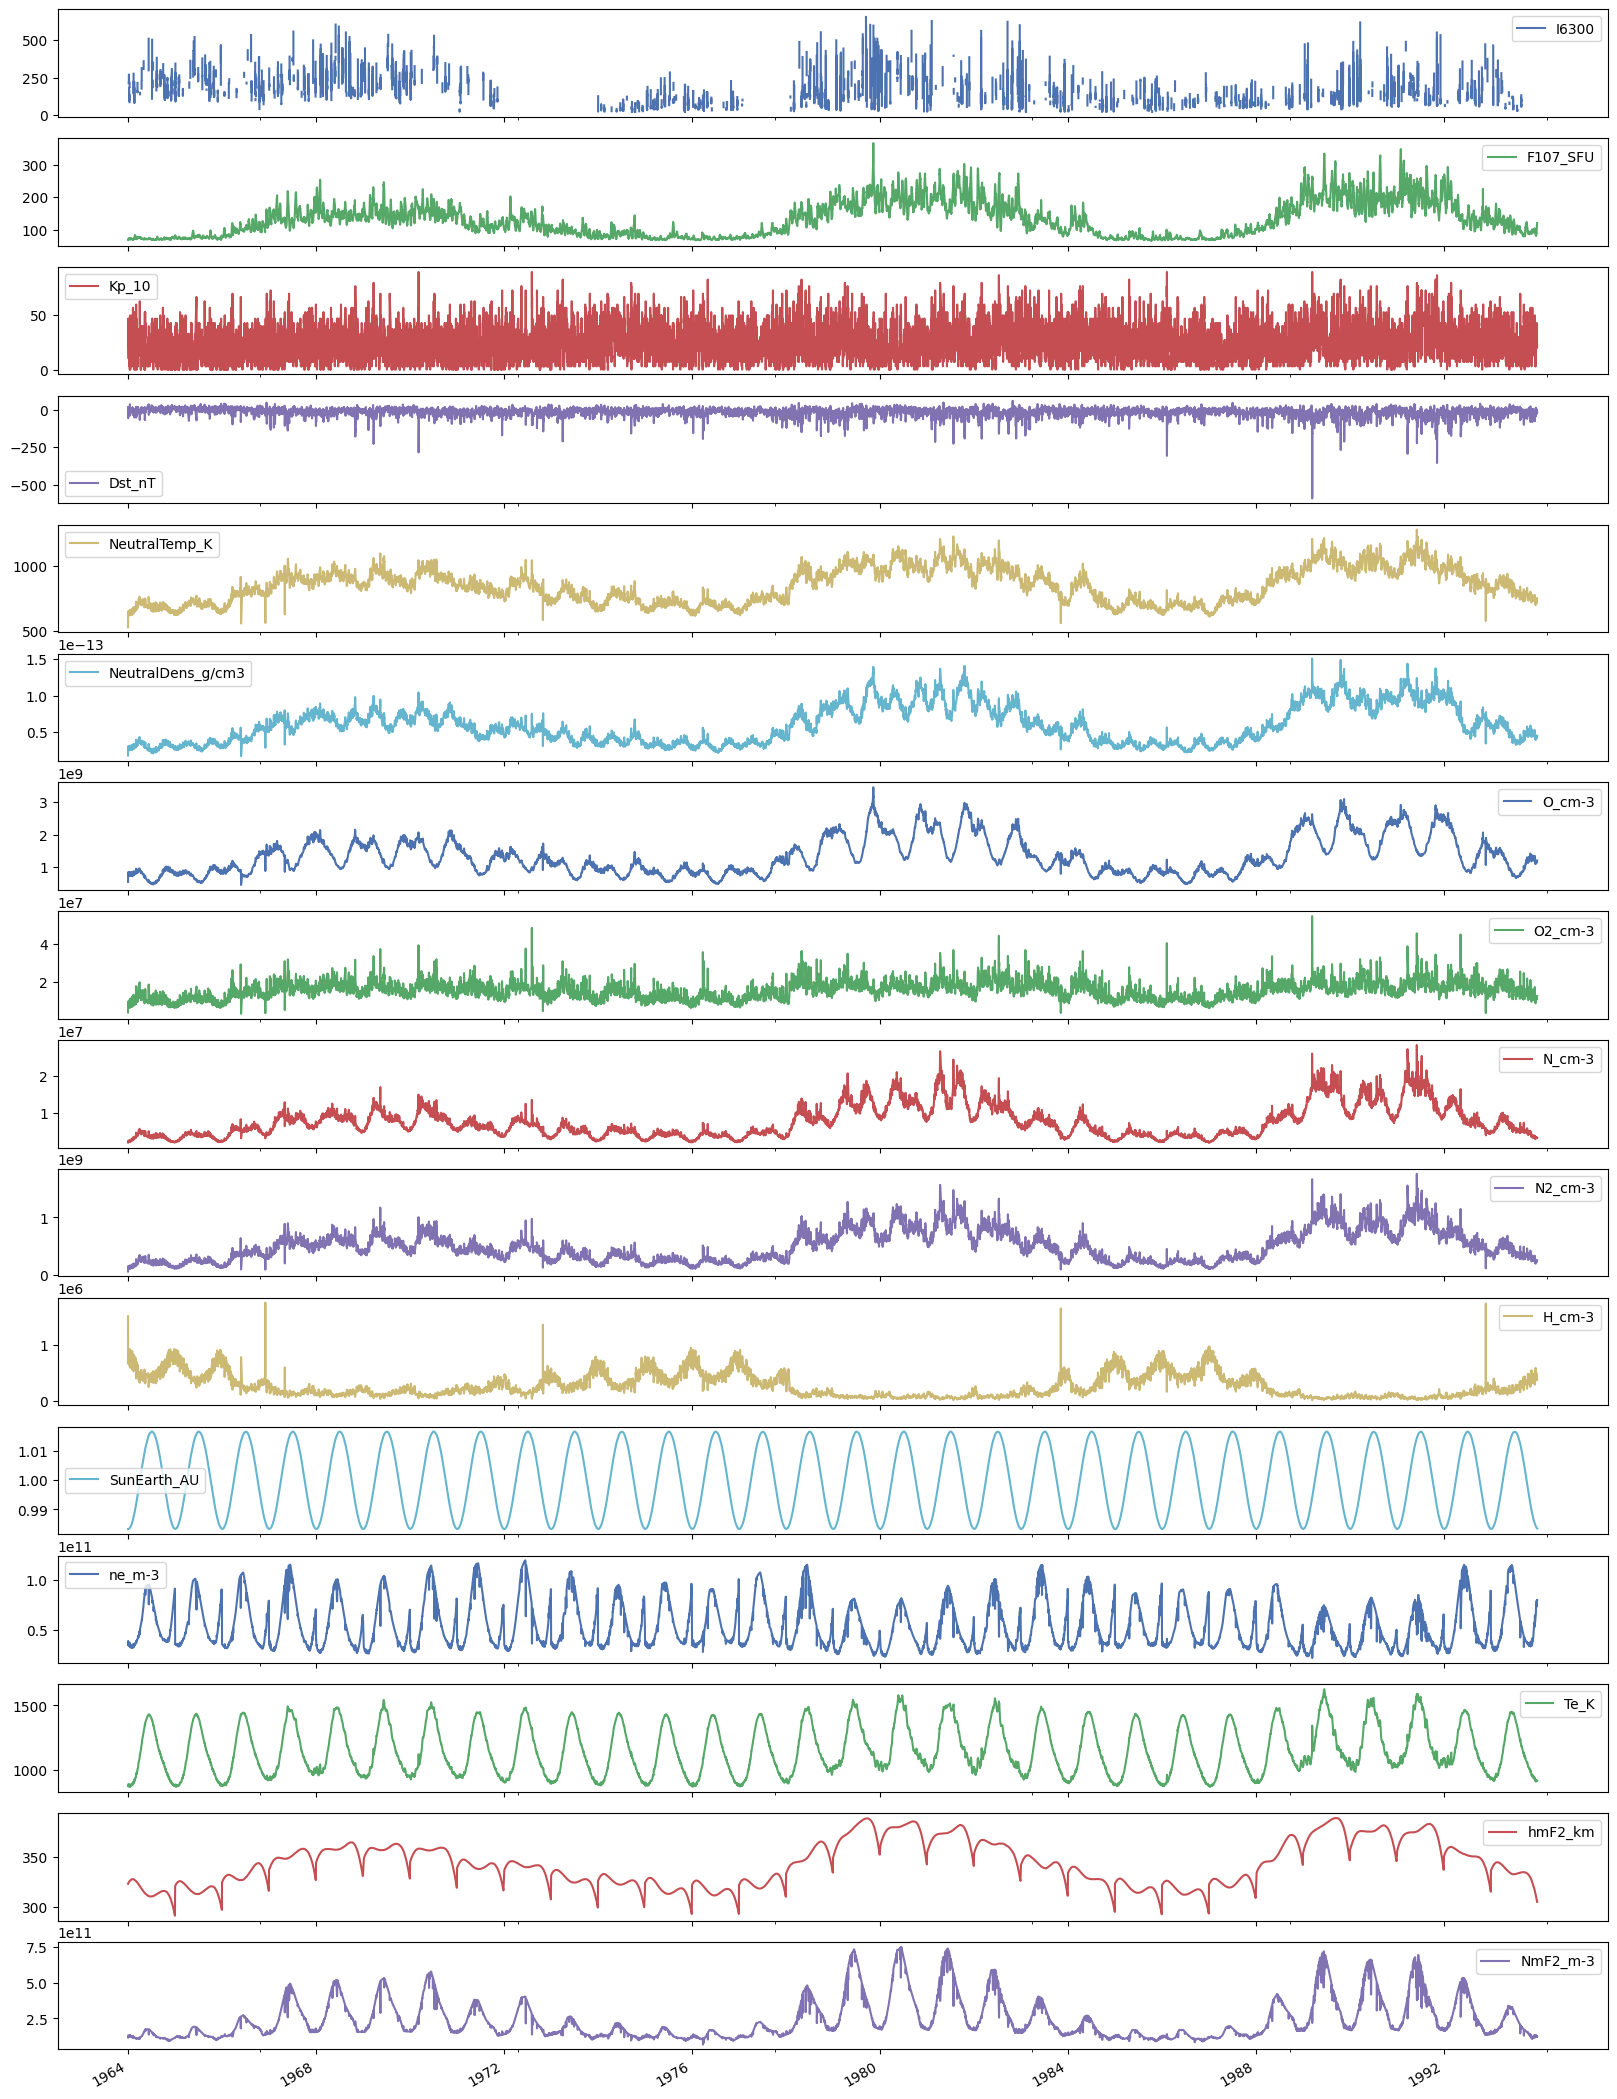

In [4]:
# quick view of data in main data frames
mdfg.plot(subplots=True, figsize=(20,30))
mdfr.plot(subplots=True, figsize=(20,30))
plt.show()

In [5]:
# provide overall characteristics of the green line data frame
mdfg.describe()

,I5577,F107_SFU,Kp_10,Dst_nT,NeutralTemp_K,NeutralDens_g/cm3,O_cm-3,O2_cm-3,N_cm-3,N2_cm-3,H_cm-3,SunEarth_AU,ne_m-3,Te_K,hmF2_km,NmF2_m-3
count,3802.00,46186.00,46222.00,46222.00,46222.00,4.62e+04,4.62e+04,4.62e+04,46222.00,4.62e+04,4.62e+04,46222.00,4.62e+04,46222.00,46222.00,4.62e+04
mean,574.55,130.09,24.55,-17.96,178.97,1.39e-09,4.85e+11,5.39e+12,175339.84,2.32e+13,3.62e+07,1.00,2.36e+09,177.29,343.16,2.22e+11
std,344.43,52.47,14.53,24.31,3.59,9.38e-11,1.09e+11,4.82e+11,25666.01,1.53e+12,5.93e+06,0.01,9.83e+08,4.08,22.11,1.29e+11
min,51.50,65.80,0.00,-589.00,167.55,1.02e-09,2.04e+11,3.61e+12,127900.00,1.70e+13,1.73e+07,0.98,1.44e+09,160.52,291.10,6.80e+10
25%,323.50,82.40,13.00,-28.00,177.14,1.33e-09,4.04e+11,5.03e+12,155725.00,2.21e+13,3.15e+07,0.99,1.70e+09,175.78,325.50,1.31e+11
50%,507.06,120.60,23.00,-14.00,179.41,1.39e-09,5.17e+11,5.41e+12,172927.08,2.31e+13,3.60e+07,0.99,2.10e+09,178.22,341.75,1.73e+11
75%,749.00,164.60,33.00,-3.00,181.73,1.46e-09,5.68e+11,5.74e+12,191486.46,2.43e+13,4.09e+07,1.01,2.54e+09,180.15,359.36,2.67e+11
max,2057.62,367.00,90.00,58.00,185.60,1.64e-09,7.20e+11,6.64e+12,256200.00,2.70e+13,5.25e+07,1.02,6.58e+09,184.63,389.60,7.48e+11


In [6]:
# provide overall characteristics of the red line data frame
mdfr.describe()

,I6300,F107_SFU,Kp_10,Dst_nT,NeutralTemp_K,NeutralDens_g/cm3,O_cm-3,O2_cm-3,N_cm-3,N2_cm-3,H_cm-3,SunEarth_AU,ne_m-3,Te_K,hmF2_km,NmF2_m-3
count,3837.00,46186.00,46222.00,46222.00,46222.00,4.62e+04,4.62e+04,4.62e+04,4.62e+04,4.62e+04,4.62e+04,46222.00,4.62e+04,46222.00,46222.00,4.62e+04
mean,162.60,130.09,24.55,-17.96,840.57,6.06e-14,1.40e+09,1.50e+07,7.22e+06,4.80e+08,2.87e+05,1.00,5.03e+10,1107.85,343.16,2.22e+11
std,105.78,52.47,14.53,24.31,131.09,2.59e-14,5.80e+08,4.65e+06,4.18e+06,2.59e+08,2.21e+05,0.01,2.13e+10,176.38,22.11,1.29e+11
min,20.00,65.80,0.00,-589.00,528.10,1.73e-14,4.62e+08,2.88e+06,1.90e+06,6.78e+07,1.06e+04,0.98,2.25e+10,869.00,291.10,6.80e+10
25%,82.67,82.40,13.00,-28.00,722.90,3.75e-14,9.18e+08,1.17e+07,4.00e+06,2.61e+08,1.06e+05,0.99,3.46e+10,963.53,325.50,1.31e+11
50%,138.50,120.60,23.00,-14.00,839.15,5.61e-14,1.27e+09,1.48e+07,6.09e+06,4.28e+08,2.12e+05,0.99,4.14e+10,1059.55,341.75,1.73e+11
75%,215.00,164.60,33.00,-3.00,942.80,8.07e-14,1.80e+09,1.78e+07,9.29e+06,6.46e+08,4.31e+05,1.01,6.25e+10,1220.53,359.36,2.67e+11
max,675.00,367.00,90.00,58.00,1280.20,1.51e-13,3.45e+09,5.50e+07,2.83e+07,1.75e+09,1.75e+06,1.02,1.20e+11,1626.17,389.60,7.48e+11


In [7]:
# display pairwise correlation of features with label for green line
mdfg.corr(method='pearson').iloc[:1, 1:]

,F107_SFU,Kp_10,Dst_nT,NeutralTemp_K,NeutralDens_g/cm3,O_cm-3,O2_cm-3,N_cm-3,N2_cm-3,H_cm-3,SunEarth_AU,ne_m-3,Te_K,hmF2_km,NmF2_m-3
I5577,0.09,-0.03,0.02,0.03,-0.05,-0.09,-0.13,0.09,-0.01,-0.13,0.2,0.17,-3.89e-03,0.15,0.18


In [8]:
# display pairwise correlation of features with label for red line
mdfr.corr(method='pearson').iloc[:1, 1:]

,F107_SFU,Kp_10,Dst_nT,NeutralTemp_K,NeutralDens_g/cm3,O_cm-3,O2_cm-3,N_cm-3,N2_cm-3,H_cm-3,SunEarth_AU,ne_m-3,Te_K,hmF2_km,NmF2_m-3
I6300,0.24,-0.12,0.12,0.25,0.19,0.15,0.14,0.19,0.22,-0.23,0.11,0.14,0.19,0.22,0.26


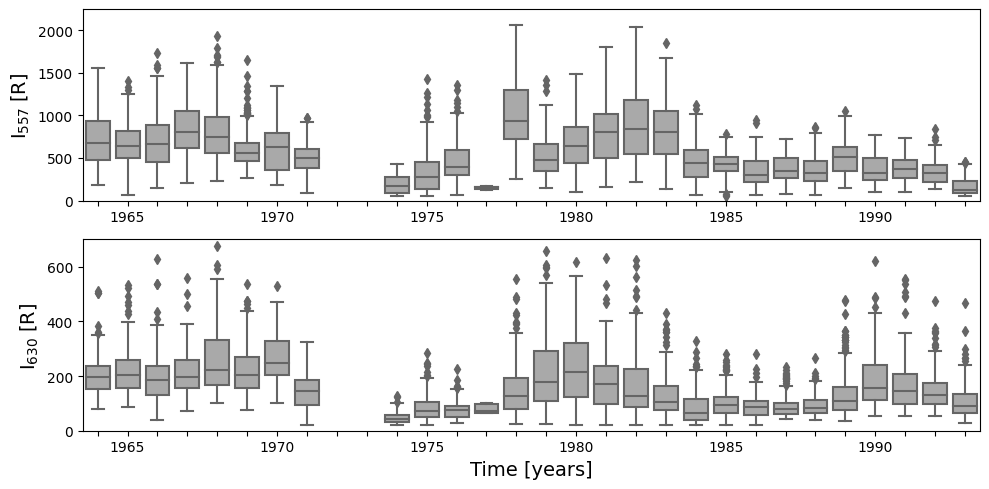

In [9]:
# vizualize the airglow intensities measured in Abastumani (Georgia)
# they will be used as labels (targets) for machine learning techniques

# set the labels for x axis
mdfg['Time [years]'] = mdfg.index.year
mdfr['Time [years]'] = mdfr.index.year
year_labels = [None, 1965, None, None, None, None, 1970,
               None, None, None, None, 1975, None, None, None, None, 1980,
               None, None, None, None, 1985, None, None, None, None, 1990,
               None, None, None]

# plot Figure 1
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.ylim(0, 2250)
sns.boxplot(x=mdfg['Time [years]'][mdfg['I5577'].notna()], y=mdfg.I5577[mdfg['I5577'].notna()], order=mdfg['Time [years]'].unique(), \
            color='darkgray').set(xlabel=None, ylabel='I$_{557}$ [R]', xticklabels=year_labels)
plt.subplot(212)
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.ylim(0, 700)
sns.boxplot(x=mdfr['Time [years]'][mdfr['I6300'].notna()], y=mdfr.I6300[mdfr['I6300'].notna()], order=mdfg['Time [years]'].unique(), \
            color='darkgray').set(xlabel='Time [years]', ylabel='I$_{630}$ [R]', xticklabels=year_labels)

plt.tight_layout()
plt.show()
#plt.savefig('figure1.eps', format='eps', dpi=600)

# remove column that will be not needed
mdfg.drop('Time [years]', axis=1, inplace=True)
mdfr.drop('Time [years]', axis=1, inplace=True)

# 2. Machine learning techniques

## 2.1 Linear regression

In [10]:
# define the methods that will be used for exploreed ML techniques

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


def split_and_scale(X, y, poly_feats=False, poly_degree=2, random_state=42, 
                    shuffle=True, return_test_index=False):
  """
  Method for spliting the main dataset to train and test sub-sets. The features 
  are standardized by removing the mean and scaling to unit variance.
  :X - 2D array of features
  :y - 1D array of labels
  :poly_feats - polynomial features are used only for specific case of linear regression
  :poly_degree - degree of polnomial features
  :random_state - controls the shuffling applied to the data before applying the split
  :shuffle - whether or not to shuffle the data before splitting
  :return_test_index - condition to return time index of the test subset    
  """
  if poly_feats:
      poly_trans = PolynomialFeatures(degree=poly_degree, include_bias=False)
      X = poly_trans.fit_transform(X)
  
  # split data to train (80%) and test (20%) subset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=random_state, shuffle=shuffle)
  
  # if time is added as the last column in array
  if return_test_index:
    X_test_index = X_test[:, -1]
    X_train = X_train[:, :-1]
    X_test = X_test[:, :-1]

  print('Number of features: ', X_train.shape[1])

  # normalize data
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_test)

  # test index will be used only for XGBoost section 
  # XGBoost technique doesn't require normalized data
  if return_test_index:
    return X_train, X_test, y_train, y_test, X_test_index
    
  return X_train_sc, X_test_sc, y_train, y_test


def mean_absolute_percentage_error(y_true, y_pred):
  """
  Method for calculation of mean absolute percentage error
  :y_true - labels from the dataset
  :y_pred - predicted values by the model
  """
  y_true_np, y_pred_np = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true_np - y_pred_np) / y_true_np)) * 100


def evaluate_model(X_train, X_test, y_train, y_test, model, R2_score=True):
  """
  Method for evaluation of the model performance.
  :X_train - array of features for training 
  :X_test - array of features for testing 
  :y_train - vector of labels for training 
  :y_test - vector of labels for testing
  :model - model to be evaluated 
  :R2_score - whether or not to calculate R^2 metric 
  """
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  if R2_score:
    r2_train = round(model.score(X_train, y_train), 2)
    r2_test =  round(model.score(X_test, y_test), 2)
  else:
    r2_train = 'N/A'
    r2_test = 'N/A'

  print("Model evaluation:")
  print(f'Train dataset: R^2 score: {r2_train} | \
  MAE: {round(mean_absolute_error(y_train, y_train_pred))} | \
  MAPE: {round(mean_absolute_percentage_error(y_train, y_train_pred))}%' )
  
  print(f' Test dataset: R^2 score: {r2_test} | \
  MAE: {round(mean_absolute_error(y_test, y_test_pred))} | \
  MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred))}%')
  print()


In [11]:
# prepare inputs for the model. NaN values need to be dropped. 

def prepare_data(add_time_column=False, used_subset=1):
  """
  Method for preparation of features (X) and labels (y) for the ML model.
  :add_time_columns - it is needed if test index is required
  :used_subset - ratio of used dataset rows for training and testing 
  """
  mlmdfg = mdfg[mdfg['I5577'].notna()].copy(deep=True)
  mlmdfg.dropna(inplace=True)
  mlmdfg = mlmdfg.iloc[:int(len(mlmdfg)*used_subset),:]
  mlmdfr = mdfr[mdfr['I6300'].notna()].copy(deep=True)
  mlmdfr.dropna(inplace=True)
  mlmdfr = mlmdfr.iloc[:int(len(mlmdfr)*used_subset),:]
  
  if add_time_column:
    mlmdfg['Time_UTC'] = mlmdfg.index
    mlmdfr['Time_UTC'] = mlmdfr.index

  # pandas DFs need to be converted tu numpy arrays 
  Xg = mlmdfg.iloc[:, 1:].values
  yg = mlmdfg.iloc[:, 0].values
  Xr = mlmdfr.iloc[:, 1:].values
  yr = mlmdfr.iloc[:, 0].values
  return Xg, yg, Xr, yr


In [12]:
# evaluate "Baseline" mean model

Xg, yg, Xr, yr = prepare_data()

print('I5577 (green line)')
X_train, X_test, y_train, y_test = split_and_scale(Xg, yg, poly_feats=False, shuffle=True)
print(f'Baseline MAE: {round(np.mean(np.abs(y_test - np.mean(y_train))))} | \
Baseline MAPE: {round(np.mean(np.abs((y_test - np.mean(y_train))) / y_test) * 100)}%\n')

print('I6300 (red line)')
X_train, X_test, y_train, y_test = split_and_scale(Xr, yr, poly_feats=False, shuffle=True)
print(f'Baseline MAE: {round(np.mean(np.abs(y_test - np.mean(y_train))))} | \
Baseline MAPE: {round(np.mean(np.abs((y_test - np.mean(y_train))) / y_test) * 100)}%\n')

I5577 (green line)
Number of features:  15
Baseline MAE: 265.0 | Baseline MAPE: 78.0%

I6300 (red line)
Number of features:  15
Baseline MAE: 84.0 | Baseline MAPE: 86.0%



In [13]:
# train and evaluate the Linear regression model

from sklearn.linear_model import LinearRegression

Xg, yg, Xr, yr = prepare_data()
lr_model = LinearRegression()

print('I5577 (green line)')
X_train, X_test, y_train, y_test = split_and_scale(Xg, yg, poly_feats=False, shuffle=True)
lr_model.fit(X_train, y_train)
evaluate_model(X_train, X_test, y_train, y_test, lr_model)

print('I6300 (red line)')
X_train, X_test, y_train, y_test = split_and_scale(Xr, yr, poly_feats=False, shuffle=True)
lr_model.fit(X_train, y_train)
evaluate_model(X_train, X_test, y_train, y_test, lr_model)

I5577 (green line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 0.18 |   MAE: 242.0 |   MAPE: 67.0%
 Test dataset: R^2 score: 0.14 |   MAE: 247.0 |   MAPE: 65.0%

I6300 (red line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 0.14 |   MAE: 75.0 |   MAPE: 71.0%
 Test dataset: R^2 score: 0.13 |   MAE: 77.0 |   MAPE: 72.0%



In [14]:
# by using polynomial features (degree 2), the linear regression might have better performance

print('I5577 (green line)')
X_train, X_test, y_train, y_test = split_and_scale(Xg, yg, poly_feats=True, 
                                                   poly_degree=2, shuffle=True)
lr_model.fit(X_train, y_train)
evaluate_model(X_train, X_test, y_train, y_test, lr_model)


print('I6300 (red line)')
X_train, X_test, y_train, y_test = split_and_scale(Xr, yr, poly_feats=True, 
                                                   poly_degree=2, shuffle=True)
lr_model.fit(X_train, y_train)
evaluate_model(X_train, X_test, y_train, y_test, lr_model)

I5577 (green line)
Number of features:  135
Model evaluation:
Train dataset: R^2 score: 0.39 |   MAE: 205.0 |   MAPE: 56.0%
 Test dataset: R^2 score: 0.36 |   MAE: 211.0 |   MAPE: 57.0%

I6300 (red line)
Number of features:  135
Model evaluation:
Train dataset: R^2 score: 0.29 |   MAE: 66.0 |   MAPE: 60.0%
 Test dataset: R^2 score: 0.12 |   MAE: 72.0 |   MAPE: 64.0%



## 2.2 Neural Network

In [47]:
# train and evaluate the Neural Network model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

Xg, yg, Xr, yr = prepare_data()

print('I5577 (green line)')
# define NN model
nn_model = Sequential([Dense(128, input_shape=(len(Xg[0]),)),
                       BatchNormalization(),
                       Activation('tanh'),
                       Dropout(0.2),
                       Dense(128),
                       BatchNormalization(),
                       Activation('tanh'),
                       Dropout(0.1),
                       Dense(1)])
optimizer = Adam(lr=0.1)
lr_scheduler = LearningRateScheduler(schedule=lambda epoch, lr: lr*0.8 \
                                     if epoch % 100 == 0 else lr, verbose=0)

# split and scale data
X_train, X_test, y_train, y_test = split_and_scale(Xg, yg, poly_feats=False)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# train model
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=300, batch_size=128, \
          validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=0)

#evaluate model
evaluate_model(X_train, X_test, y_train, y_test, nn_model, R2_score=False)

I5577 (green line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: N/A |   MAE: 105.0 |   MAPE: 99.0%
 Test dataset: R^2 score: N/A |   MAE: 146.0 |   MAPE: 95.0%



In [48]:
print('I6300 (red line)')
# define NN model
nn_model = Sequential([Dense(128, input_shape=(len(Xr[0]),)),
                       BatchNormalization(),
                       Activation('tanh'),
                       Dropout(0.2),
                       Dense(128),
                       BatchNormalization(),
                       Activation('tanh'),
                       Dropout(0.1),
                       Dense(1)])
optimizer = Adam(lr=0.1)
lr_scheduler = LearningRateScheduler(schedule=lambda epoch, lr: lr*0.8 \
                                     if epoch % 100 == 0 else lr, verbose=0)

# split and scale data
X_train, X_test, y_train, y_test = split_and_scale(Xr, yr, poly_feats=False)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# train model
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=300, batch_size=128, \
              validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=0)

#evaluate model
evaluate_model(X_train, X_test, y_train, y_test, nn_model, R2_score=False)

I6300 (red line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: N/A |   MAE: 49.0 |   MAPE: 90.0%
 Test dataset: R^2 score: N/A |   MAE: 63.0 |   MAPE: 90.0%



## 2.3 Random Forest

In [17]:
# train and evaluate the Random Forest model
from sklearn.ensemble import RandomForestRegressor

Xg, yg, Xr, yr = prepare_data()

print('I5577 (green line)')
X_train, X_test, y_train, y_test = split_and_scale(Xg, yg, poly_feats=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                                 max_depth=15, min_samples_leaf=1, criterion='mse')
rf_model.fit(X_train, y_train)

evaluate_model(X_train, X_test, y_train, y_test, rf_model)

I5577 (green line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 0.96 |   MAE: 45.0 |   MAPE: 10.0%
 Test dataset: R^2 score: 0.8 |   MAE: 102.0 |   MAPE: 23.0%



In [18]:
print('I6300 (red line)')
X_train, X_test, y_train, y_test = split_and_scale(Xr, yr, poly_feats=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                                 max_depth=15, min_samples_leaf=1, criterion='mse')
rf_model.fit(X_train, y_train)

evaluate_model(X_train, X_test, y_train, y_test, rf_model)

I6300 (red line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 0.87 |   MAE: 27.0 |   MAPE: 23.0%
 Test dataset: R^2 score: 0.46 |   MAE: 53.0 |   MAPE: 41.0%



## 2.4 XGBoost

In [19]:
# this value could be from interval <0,1> 
# it represents a ratio of subset rows to all rows of main dataset 
# only subset rows will be used for model training and testing
# when this value is changed, RUN all after to see the results for the specific subset
SUBSET_VALUE = 1

In [20]:
# train and evaluate the XGBoost model
import xgboost as xgb

# preapre data
print('I5577 (green line)')
Xg, yg, Xr, yr = prepare_data(add_time_column=True, used_subset=SUBSET_VALUE)
X_train, X_test, y_train, y_test, X_test_index_g = split_and_scale(Xg, yg, poly_feats=False, return_test_index=True)
Xg = Xg[:, :-1]

# define and train model
xgb_model_g = xgb.XGBRegressor(objective='reg:squarederror',
                          colsample_bytree=0.6,
                          learning_rate=0.05,
                          min_child_weight=1,
                          n_estimators = 100,
                          max_depth=15)
xgb_model_g.fit(X_train, y_train)

# evaluate model
evaluate_model(X_train, X_test, y_train, y_test, xgb_model_g)

# define variables for next usage
y_test_pred_g = xgb_model_g.predict(X_test)
y_test_g = y_test

I5577 (green line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 1.0 |   MAE: 11.0 |   MAPE: 2.0%
 Test dataset: R^2 score: 0.84 |   MAE: 88.0 |   MAPE: 16.0%



In [21]:
# preapre data
print('I6300 (red line)')
Xg, yg, Xr, yr = prepare_data(add_time_column=True, used_subset=SUBSET_VALUE)
X_train, X_test, y_train, y_test, X_test_index_r = split_and_scale(Xr, yr, poly_feats=False, return_test_index=True)
Xr = Xr[:, :-1]

# define and train model
xgb_model_r = xgb.XGBRegressor(objective='reg:squarederror',
                          colsample_bytree=0.6,
                          learning_rate=0.05,
                          min_child_weight=1,
                          n_estimators = 100,
                          max_depth=15)
xgb_model_r.fit(X_train, y_train)

# evaluate model
evaluate_model(X_train, X_test, y_train, y_test, xgb_model_r)

# define variables for next usage
y_test_pred_r = xgb_model_r.predict(X_test)
y_test_r = y_test

I6300 (red line)
Number of features:  15
Model evaluation:
Train dataset: R^2 score: 0.99 |   MAE: 7.0 |   MAPE: 5.0%
 Test dataset: R^2 score: 0.5 |   MAE: 48.0 |   MAPE: 32.0%



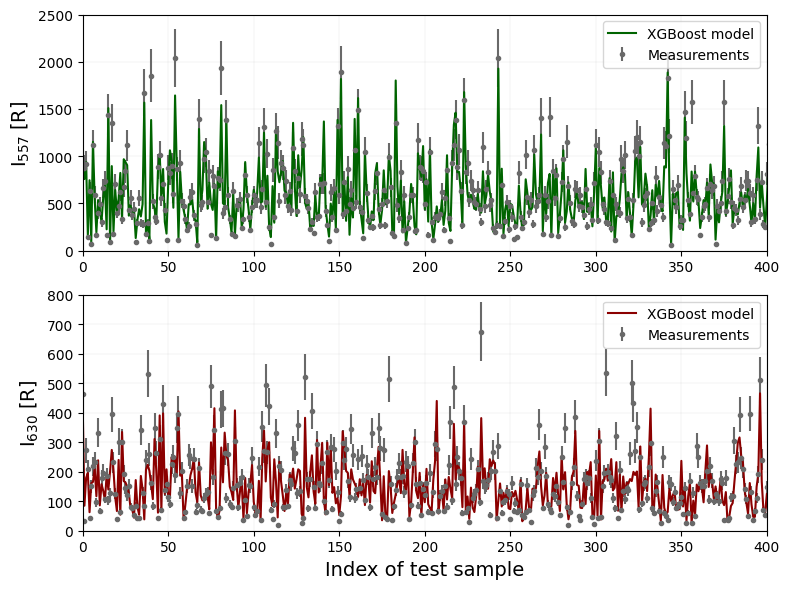

In [22]:
# Visualization of modeled values and measured values in test set
# data are shuffled  (not in time order)

plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(0, 400)
plt.ylim(0, 2500)
plt.grid(linewidth=0.1)
xig=np.arange(0,len(y_test_g))
plt.errorbar(xig, y_test_g, y_test_g*0.15, fmt='.', color='dimgray', label='Measurements')
plt.plot(xig, y_test_pred_g, color='darkgreen', label='XGBoost model')
plt.legend(loc='upper right')

plt.subplot(212)
plt.xlabel('Index of test sample', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(0, 400)
plt.ylim(0, 800)
plt.grid(linewidth=0.1)
xir=np.arange(0,len(y_test_r))
plt.errorbar(xir, y_test_r, y_test_r*0.15, fmt='.', color='dimgray', label='Measurements')
plt.plot(xir, y_test_pred_r, color='darkred', label='XGBoost model')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig('figure2.eps', format='eps', dpi=600)

In [23]:
# prepare test DFs for comparison purposes in the next section
df_test_g = pd.DataFrame({'I5577_measured': y_test_g}, index=X_test_index_g)
df_test_g.index = pd.to_datetime(df_test_g.index)
df_test_g.sort_index(inplace=True)

df_test_r = pd.DataFrame({'I6300_measured': y_test_r}, index=X_test_index_r)
df_test_r.index = pd.to_datetime(df_test_r.index)
df_test_r.sort_index(inplace=True)

In [24]:
# prepare test DFs with unseen data for training and testing (if SUBSET_VALUE < 1)
if SUBSET_VALUE < 1:
  df_unseen_g = mdfg[mdfg['I5577'].notna()].copy(deep=True)
  df_unseen_g.dropna(inplace=True)
  df_unseen_g = df_unseen_g.iloc[int(len(df_unseen_g)*SUBSET_VALUE):,:]
  df_test_unseen_g = pd.DataFrame({'I5577_measured': df_unseen_g['I5577']})

  df_unseen_r = mdfr[mdfr['I6300'].notna()].copy(deep=True)
  df_unseen_r.dropna(inplace=True)
  df_unseen_r = df_unseen_r.iloc[int(len(df_unseen_r)*SUBSET_VALUE):,:]
  df_test_unseen_r = pd.DataFrame({'I6300_measured': df_unseen_r['I6300']})

# 3. Verification of data-driven model

## 3.1. Simulated intensities by XGBoost and GLOW models

In [25]:
# calculate modeled intensities by the best ML model based on XGBoost 
# for all dark night hours within 1964 - 1993

# prepare all features for the model
xmdfg = mdfg.iloc[:, 1:].copy()
Xg_all = xmdfg.values
xmdfr = mdfr.iloc[:, 1:].copy()
Xr_all = xmdfr.values

# apply model to all features and create new DF that will containt modeled data
df_xgb = pd.DataFrame({'I5577_modeled_xgb': xgb_model_g.predict(Xg_all), 
                       'I6300_modeled_xgb': xgb_model_r.predict(Xr_all)}, 
                      index=xmdfg.index)
df_xgb

,I5577_modeled_xgb,I6300_modeled_xgb
1964-01-01 16:00:00,204.59,117.07
1964-01-02 16:00:00,186.26,93.52
1964-01-02 17:00:00,186.96,94.89
1964-01-03 16:00:00,180.33,102.44
1964-01-03 17:00:00,173.57,101.37
...,...,...
1993-12-24 01:00:00,330.22,132.83
1993-12-24 02:00:00,338.35,137.98
1993-12-25 01:00:00,318.95,125.59
1993-12-25 02:00:00,319.56,125.59


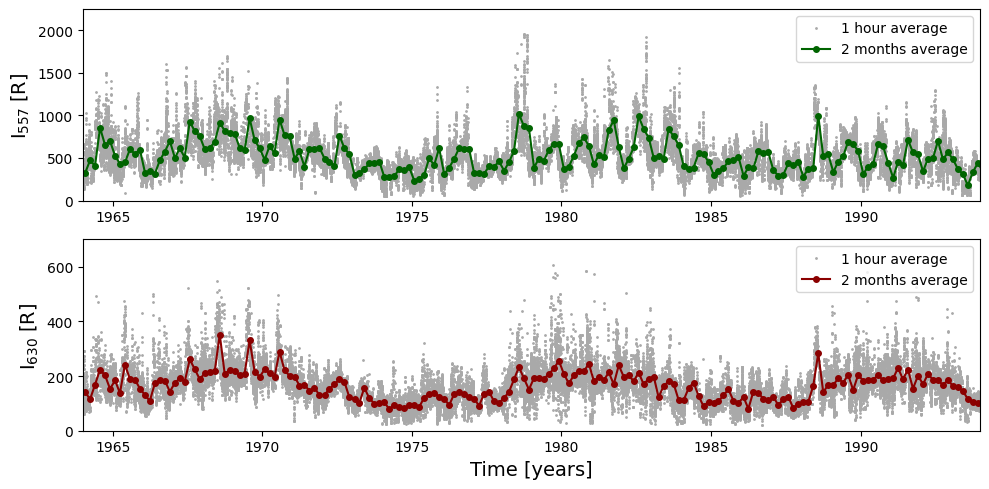

In [26]:
# plot all modeled data from our best model that is based on XGBoost

# calculate 2-month averaged values
df_xgbm = df_xgb.resample('2M').mean()

# visualize data of our model
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(df_xgb.index[0], df_xgb.index[-1])
plt.ylim(0, 2250)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_xgb.index, df_xgb.I5577_modeled_xgb, '.', color='darkgray', markersize=2, label='1 hour average')
plt.plot(df_xgbm.index, df_xgbm.I5577_modeled_xgb, '.-', color='darkgreen', markersize=8, label='2 months average')
plt.legend(loc='upper right')
plt.subplot(212)
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(df_xgb.index[0], df_xgb.index[-1])
plt.ylim(0, 700)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_xgb.index, df_xgb.I6300_modeled_xgb, '.', color='darkgray', markersize=2, label='1 hour average')
plt.plot(df_xgbm.index, df_xgbm.I6300_modeled_xgb, '.-', color='darkred', markersize=8, label='2 months average')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig('figure3.eps', format='eps', dpi=600)

In [27]:
# read the calculated data of airglow intensieties calculated by GLOW
df_glow = pd.read_pickle('https://github.com/space-lab-sk/space-lab-sk.github.io/raw/master/papers/mackovjak_2021/df_glow_1964-1993.pkl')
df_glow 

,I5577_modeled_glow,I6300_modeled_glow
date,,
1964-01-17 18:00:00,661.59,32.96
1964-01-17 19:00:00,656.85,22.60
1964-01-17 20:00:00,656.39,20.68
1964-01-17 21:00:00,667.20,28.49
1964-01-17 22:00:00,672.14,53.08
...,...,...
1993-12-23 02:00:00,619.94,28.67
1993-12-24 01:00:00,601.12,46.87
1993-12-24 02:00:00,605.56,30.96


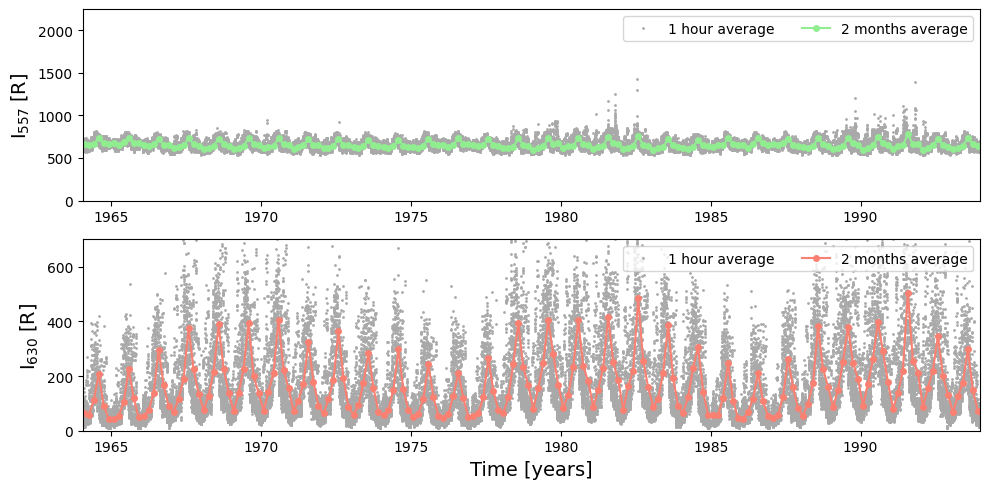

In [28]:
# plot all modeled data from GLOW model

# calculate 2-month averaged values
df_glowm = df_glow.resample('2M').mean()

# visualize GLOW data
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(df_glow.index[0], df_glow.index[-1])
plt.ylim(0, 2250)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_glow.index, df_glow.I5577_modeled_glow, '.', color='darkgray', markersize=2, label='1 hour average')
plt.plot(df_glowm.index, df_glowm.I5577_modeled_glow, '.-', color='lightgreen', markersize=8, label='2 months average')
plt.legend(loc='upper right', ncol=2)
plt.subplot(212)
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(df_glow.index[0], df_glow.index[-1])
plt.ylim(0, 700)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_glow.index, df_glow.I6300_modeled_glow, '.', color='darkgray', markersize=2, label='1 hour average')
plt.plot(df_glowm.index, df_glowm.I6300_modeled_glow,  '.-', color='salmon', markersize=8, label='2 months average')
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

In [29]:
# add XGB and GLOW data to the test DF
df_test_g = pd.concat([df_test_g, df_xgb.I5577_modeled_xgb], axis=1, join='inner')
df_test_g = pd.concat([df_test_g, df_glow.I5577_modeled_glow], axis=1, join='inner')
print(df_test_g)
df_test_r = pd.concat([df_test_r, df_xgb.I6300_modeled_xgb], axis=1, join='inner')
df_test_r = pd.concat([df_test_r, df_glow.I6300_modeled_glow], axis=1, join='inner')
print(df_test_r)

# compare precision of XGB model and GLOW model against the testing set
print(f'\nGreen line -  XGB model: \
MAE: {round(mean_absolute_error(df_test_g.I5577_measured, df_test_g.I5577_modeled_xgb))} | \
MAPE: {round(mean_absolute_percentage_error(df_test_g.I5577_measured, df_test_g.I5577_modeled_xgb))}%')

print(f'Green line - GLOW model: \
MAE: {round(mean_absolute_error(df_test_g.I5577_measured, df_test_g.I5577_modeled_glow))} | \
MAPE: {round(mean_absolute_percentage_error(df_test_g.I5577_measured, df_test_g.I5577_modeled_glow))}%')

print(f'\nRed line -  XGB model: \
MAE: {round(mean_absolute_error(df_test_r.I6300_measured, df_test_r.I6300_modeled_xgb))} | \
MAPE: {round(mean_absolute_percentage_error(df_test_r.I6300_measured, df_test_r.I6300_modeled_xgb))}%')

print(f'Red line - GLOW model: \
MAE: {round(mean_absolute_error(df_test_r.I6300_measured, df_test_r.I6300_modeled_glow))} | \
MAPE: {round(mean_absolute_percentage_error(df_test_r.I6300_measured, df_test_r.I6300_modeled_glow))}%')

                     I5577_measured  I5577_modeled_xgb  I5577_modeled_glow
1964-02-13 17:00:00          708.00             770.82              630.18
1964-03-14 19:00:00          835.00             739.69              599.81
1964-03-14 22:00:00         1163.00             823.14              605.14
1964-03-14 23:00:00          647.00             820.65              606.65
1964-04-03 20:00:00          534.00             609.65              615.48
...                             ...                ...                 ...
1993-07-26 22:00:00          125.43             127.08              711.06
1993-08-23 20:00:00           90.06              76.99              712.38
1993-08-23 21:00:00          108.83              89.94              703.85
1993-08-23 22:00:00          106.19              89.75              690.32
1993-08-24 20:00:00           57.64              84.31              703.46

[742 rows x 3 columns]
                     I6300_measured  I6300_modeled_xgb  I6300_modeled_glow
1

In [30]:
# add XGB and GLOW data to the test unseen DF
if SUBSET_VALUE < 1:
  df_test_unseen_g = pd.concat([df_test_unseen_g, df_xgb.I5577_modeled_xgb], axis=1, join='inner')
  df_test_unseen_g = pd.concat([df_test_unseen_g, df_glow.I5577_modeled_glow], axis=1, join='inner')
  print(df_test_unseen_g)
  df_test_unseen_r = pd.concat([df_test_unseen_r, df_xgb.I6300_modeled_xgb], axis=1, join='inner')
  df_test_unseen_r = pd.concat([df_test_unseen_r, df_glow.I6300_modeled_glow], axis=1, join='inner')
  print(df_test_unseen_r)

  # compare precision of XGB model and GLOW model against the testing set
  print(f'\nGreen line -  XGB model: \
  MAE: {round(mean_absolute_error(df_test_unseen_g.I5577_measured, df_test_unseen_g.I5577_modeled_xgb))} | \
  MAPE: {round(mean_absolute_percentage_error(df_test_unseen_g.I5577_measured, df_test_unseen_g.I5577_modeled_xgb))}%')

  print(f'Green line - GLOW model: \
  MAE: {round(mean_absolute_error(df_test_unseen_g.I5577_measured, df_test_unseen_g.I5577_modeled_glow))} | \
  MAPE: {round(mean_absolute_percentage_error(df_test_unseen_g.I5577_measured, df_test_unseen_g.I5577_modeled_glow))}%')

  print(f'\nRed line -  XGB model: \
  MAE: {round(mean_absolute_error(df_test_unseen_r.I6300_measured, df_test_unseen_r.I6300_modeled_xgb))} | \
  MAPE: {round(mean_absolute_percentage_error(df_test_unseen_r.I6300_measured, df_test_unseen_r.I6300_modeled_xgb))}%')

  print(f'Red line - GLOW model: \
  MAE: {round(mean_absolute_error(df_test_unseen_r.I6300_measured, df_test_unseen_r.I6300_modeled_glow))} | \
  MAPE: {round(mean_absolute_percentage_error(df_test_unseen_r.I6300_measured, df_test_unseen_r.I6300_modeled_glow))}%')

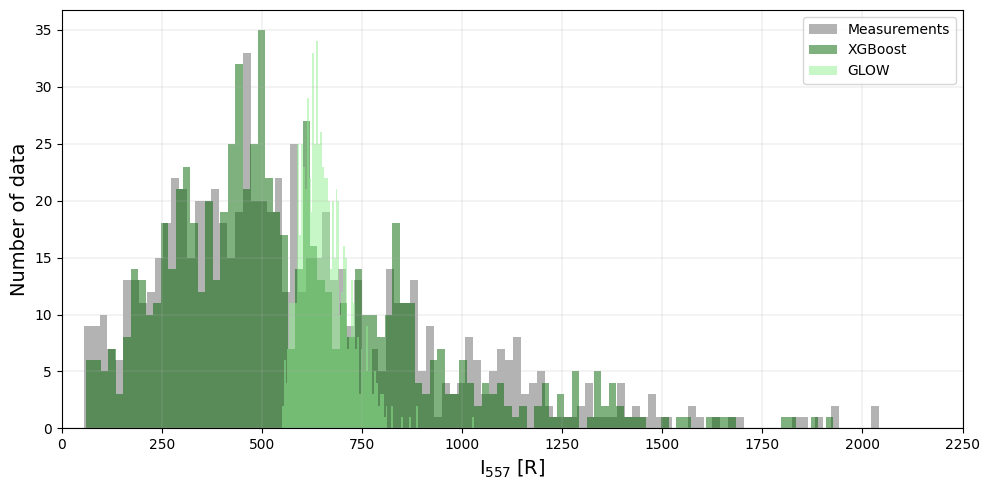

In [31]:
# Compare the distributions of the test subset for the green line
plt.figure(figsize=(10, 5))
plt.grid(linewidth=0.2)
plt.xlim(0,2250)
plt.xlabel('I$_{557}$ [R]', fontsize=14)
plt.ylabel('Number of data', fontsize=14)
df_test_g['I5577_measured'].hist(bins=100, color='dimgray', alpha=0.5, label='Measurements')
df_test_g['I5577_modeled_xgb'].hist(bins=100, color='darkgreen', alpha=0.5, label='XGBoost')
df_test_g['I5577_modeled_glow'].hist(bins=100, color='lightgreen', alpha=0.5, label='GLOW')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

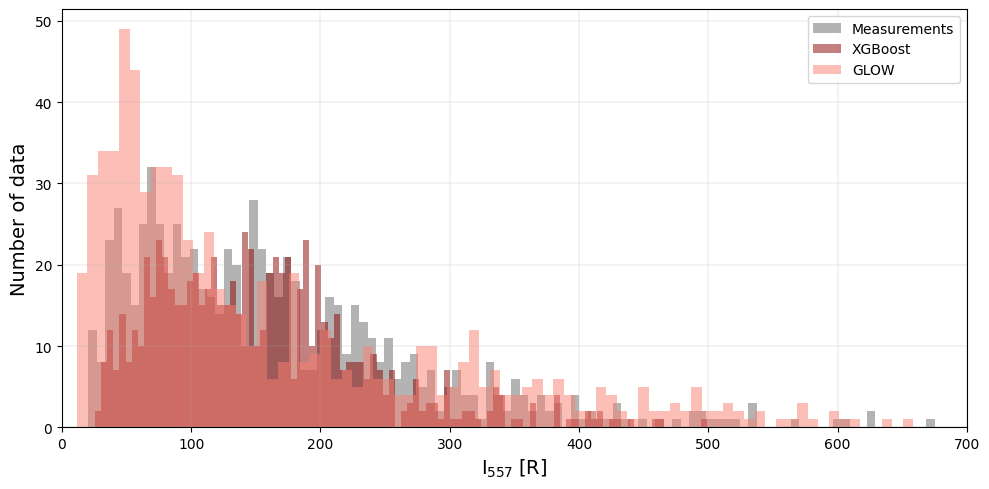

In [32]:
# Compare the distributions of the test subset for the red line
plt.figure(figsize=(10, 5))
plt.grid(linewidth=0.2)
plt.xlim(0,700)
plt.xlabel('I$_{557}$ [R]', fontsize=14)
plt.ylabel('Number of data', fontsize=14)
df_test_r['I6300_measured'].hist(bins=100, color='dimgray', alpha=0.5, label='Measurements')
df_test_r['I6300_modeled_xgb'].hist(bins=100, color='darkred', alpha=0.5, label='XGBoost')
df_test_r['I6300_modeled_glow'].hist(bins=100, color='salmon', alpha=0.5, label='GLOW')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [33]:
# concat dataframes to have all GLOW and XGBoost data for the same time
# and averaged them over 2 months
df_m = pd.concat([df_glow, df_xgb], axis=1, join='inner')
df_mm = df_m.resample('2M').mean()
df_mm

,I5577_modeled_glow,I6300_modeled_glow,I5577_modeled_xgb,I6300_modeled_xgb
1964-01-31,663.84,63.44,345.20,91.73
1964-03-31,652.92,56.48,472.03,114.90
1964-05-31,665.11,110.76,407.25,168.04
1964-07-31,737.33,206.45,854.44,224.02
1964-09-30,676.44,91.39,653.65,202.72
...,...,...,...,...
1993-05-31,644.04,175.70,308.25,145.22
1993-07-31,729.97,297.35,174.08,115.47
1993-09-30,664.45,148.44,335.86,105.87
1993-11-30,641.85,72.44,440.20,102.88


In [34]:
# average all measured airlgow data over 2 months
mg = pd.DataFrame()
mg['I5577'] = mdfg.I5577
mg.dropna(inplace=True)
mg['I5577'] =mg['I5577'].astype(int)
mgm = mg.resample('2M').mean()
mgm['Istd'] = mg.resample('2M').std()

mr = pd.DataFrame()
mr['I6300'] = mdfr.I6300
mr.dropna(inplace=True)
mr['I6300'] =mr['I6300'].astype(int)
mrm = mr.resample('2M').mean()
mrm['Istd'] = mr.resample('2M').std()
mgm

,I5577,Istd
1964-01-31,366.24,156.51
1964-03-31,759.64,288.58
1964-05-31,568.45,211.88
1964-07-31,1003.65,266.19
1964-09-30,674.10,243.37
...,...,...
1993-01-31,112.92,22.95
1993-03-31,268.88,99.95
1993-05-31,62.00,1.73
1993-07-31,132.04,93.56


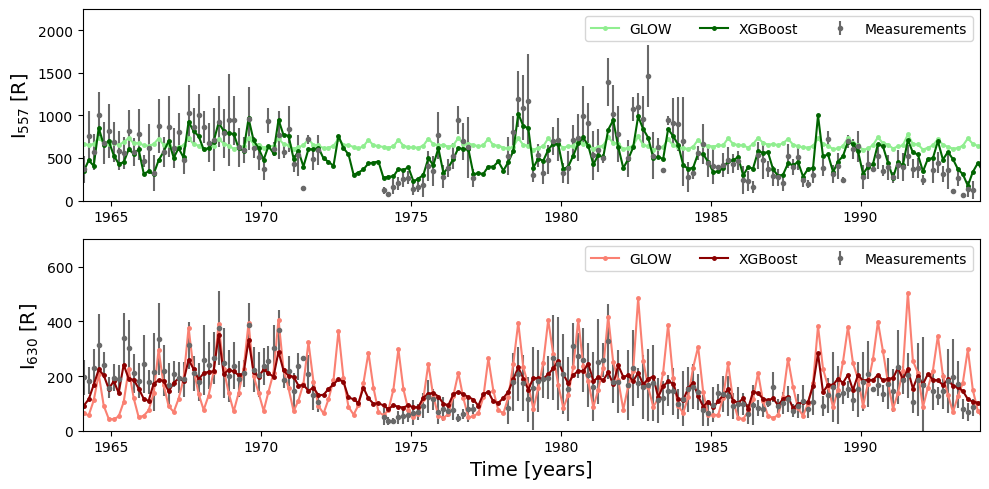

In [35]:
# plot GLOW and XGBoost data
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(df_glow.index[0], df_glow.index[-1])
plt.ylim(0, 2250)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
# size of errorbar is defined by standard deviation of 2-month mean
plt.errorbar(mgm.index, mgm.I5577, yerr=mgm.Istd, fmt='.', color='dimgray', label='Measurements')
plt.plot(df_mm.index, df_mm.I5577_modeled_glow,  '.-', color='lightgreen', markersize=5, label='GLOW')
plt.plot(df_mm.index, df_mm.I5577_modeled_xgb,  '.-', color='darkgreen', markersize=5, label='XGBoost')
plt.legend(loc='upper right', ncol=3)
plt.subplot(212)
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(df_glow.index[0], df_glow.index[-1])
plt.ylim(0, 700)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
# size of errorbar is defined by standard deviation of 2-month mean
plt.errorbar(mrm.index, mrm.I6300, yerr=mrm.Istd,  fmt='.', color='dimgray', label='Measurements')
plt.plot(df_mm.index, df_mm.I6300_modeled_glow,  '.-', color='salmon', markersize=5, label='GLOW')
plt.plot(df_mm.index, df_mm.I6300_modeled_xgb,  '.-', color='darkred', markersize=5, label='XGBoost')
plt.legend(loc='upper right', ncol=3)
plt.tight_layout()
plt.show()
#plt.savefig('figure4.eps', format='eps', dpi=600)


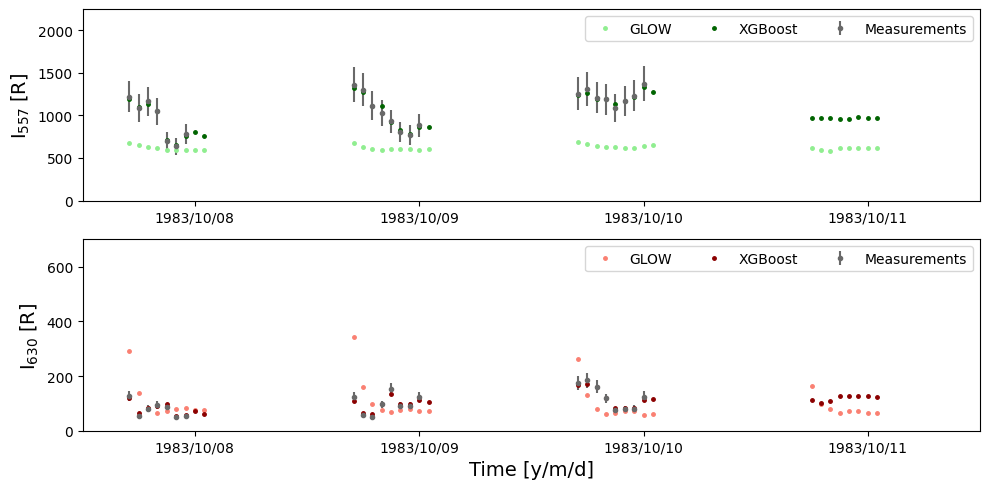

In [36]:
# visualize Measured, XGBoost and GLOW data for shorter period 
# the specific period can be set by start_year and end_year parameters
start_year = datetime.datetime.strptime('1983-10-07 12:00', "%Y-%m-%d %H:%M")
end_year = datetime.datetime.strptime('1983-10-11 12:00', "%Y-%m-%d %H:%M")

plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(0, 2250)
ax=plt.gca()
lfmt = md.DayLocator(interval=1) 
xfmt = md.DateFormatter('%Y/%m/%d')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
# size of errorbar is 15% of measured data
plt.errorbar(mg.index, mg.I5577, mg.I5577*0.15, fmt='.', color='dimgray', label='Measurements')
plt.plot(df_m.index, df_m.I5577_modeled_glow,  '.', color='lightgreen', markersize=5, label='GLOW')
plt.plot(df_m.index, df_m.I5577_modeled_xgb,  '.', color='darkgreen', markersize=5, label='XGBoost')
plt.legend(loc='upper right', ncol=3)
plt.subplot(212)
plt.xlabel('Time [y/m/d]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(0, 700)
ax=plt.gca()
lfmt = md.DayLocator(interval=1) 
xfmt = md.DateFormatter('%Y/%m/%d')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
# size of errorbar is 15% of measured data
plt.errorbar(mr.index, mr.I6300, mr.I6300*0.15,  fmt='.', color='dimgray', label='Measurements')
plt.plot(df_m.index, df_m.I6300_modeled_glow,  '.', color='salmon', markersize=5, label='GLOW')
plt.plot(df_m.index, df_m.I6300_modeled_xgb,  '.', color='darkred', markersize=5, label='XGBoost')
plt.legend(loc='upper right', ncol=3)
plt.tight_layout()
plt.show()

2.1627106042018593 -894.2200277598752 0.4760145273537582 1.2651190283587347e-11 0.29864594779826015
0.2660085059115967 119.13231196490443 0.5438305224983323 2.5431253497206778e-15 0.03068091819453384


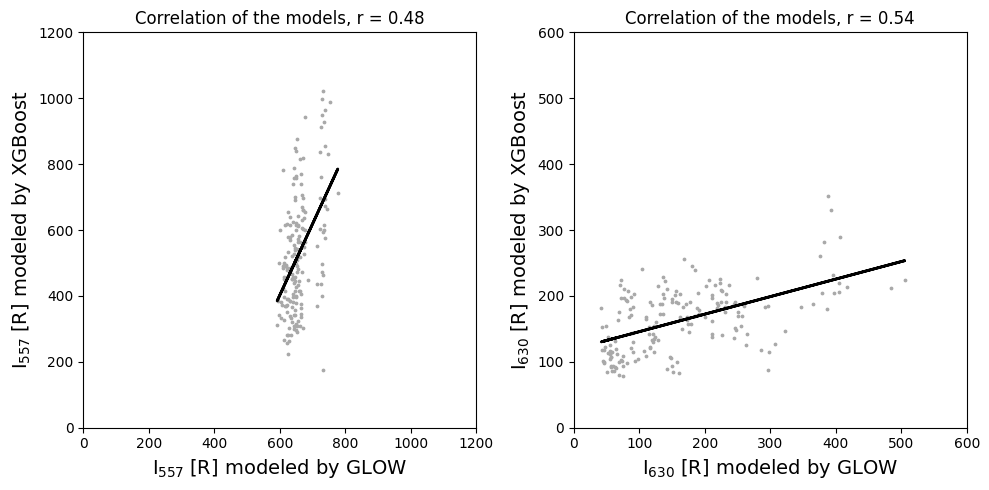

In [37]:
# calculate correlations
i557_glow = df_mm.I5577_modeled_glow
i557_xgb = df_mm.I5577_modeled_xgb
slope_557, intercept_557, r_value_557, p_value_557, std_err_557 = stats.linregress(i557_glow, i557_xgb)
print(slope_557, intercept_557, r_value_557, p_value_557, std_err_557)

i630_glow = df_mm.I6300_modeled_glow
i630_xgb = df_mm.I6300_modeled_xgb
slope_630, intercept_630, r_value_630, p_value_630, std_err_630 = stats.linregress(i630_glow, i630_xgb)
print(slope_630, intercept_630, r_value_630, p_value_630, std_err_630)


# plot correlations between XGBoost and GLOW data
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title(f'Correlation of the models, r = {round(r_value_557,2)}', fontsize=12)
plt.xlabel('I$_{557}$ [R] modeled by GLOW', fontsize=14)
plt.ylabel('I$_{557}$ [R] modeled by XGBoost', fontsize=14)
plt.ylim(0, 1200)
plt.xlim(0, 1200)
# plt.grid(linewidth=0.2)
plt.scatter(i557_glow, i557_xgb, color='darkgray', s=3)
plt.plot(i557_glow, slope_557*i557_glow+intercept_557, color='black', linewidth=2)
plt.subplot(122)
plt.title(f'Correlation of the models, r = {round(r_value_630,2)}', fontsize=12)
plt.xlabel('I$_{630}$ [R] modeled by GLOW', fontsize=14)
plt.ylabel('I$_{630}$ [R] modeled by XGBoost', fontsize=14)
plt.ylim(0, 600)
plt.xlim(0, 600)
# plt.grid(linewidth=0.2)
plt.scatter(i630_glow, i630_xgb, color='darkgray', s=3)
plt.plot(i630_glow, slope_630*i630_glow+intercept_630, color='black', linewidth=2)
plt.tight_layout()
plt.show()

In [38]:
# the previous cell can be calculated even more easily
print(f"Correlation of the models for green line, r = {round(df_mm.corr(method='pearson').iloc[0, 2],2)}")
print(f"Correlation of the models for red line, r = {round(df_mm.corr(method='pearson').iloc[1, 3],2)}")

Correlation of the models for green line, r = 0.48
Correlation of the models for red line, r = 0.54


## 3.2. Vizualization of modeled airglow variations

In [39]:
# define simple method for fiting data
def polynomial_fit(df_index, df_col, deg):
  '''
  Method to provide least squares polynomial fit of specific column of DF
  :df_index - index of DF
  :df_column - specific column of DF
  : deg - degree of the fitting polynomial
  '''
  x = np.arange(0, len(df_index.values))
  y = df_col.values
  poly_model = np.polyfit(x, y, deg)
  predict = np.poly1d(poly_model)
  return predict(x)


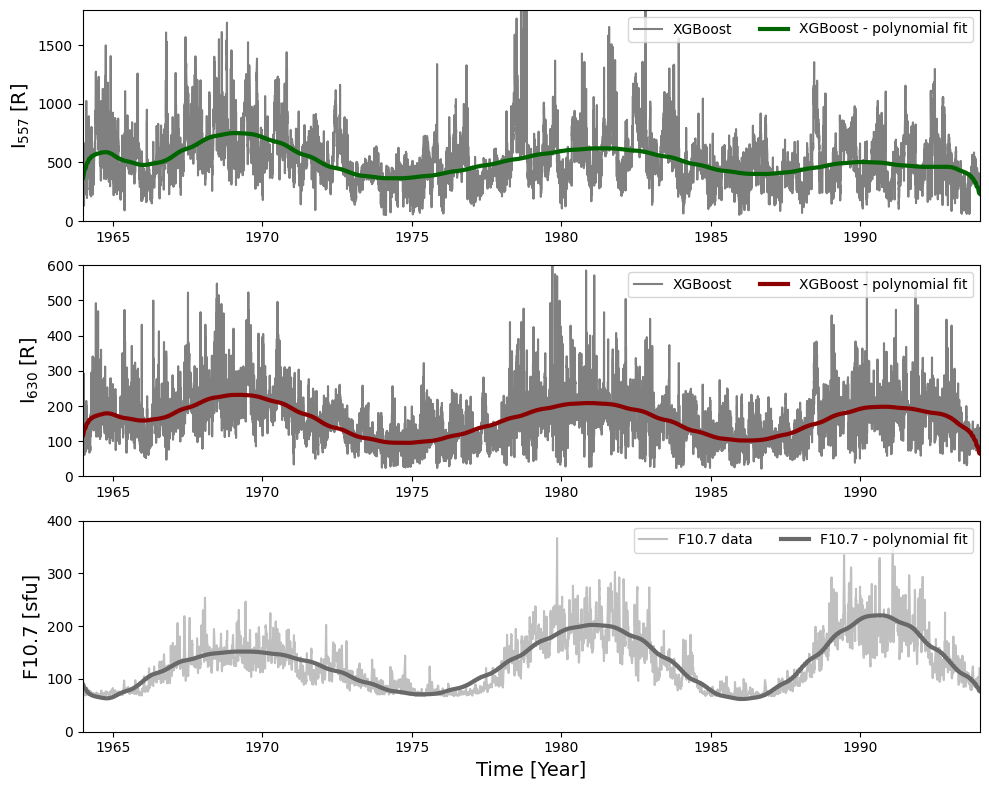

In [40]:
# 11-year variation is related with solar cycle. Airglow production is maximal during maximum of solar activity. 

start_year = datetime.datetime.strptime('1964-01-01 00:00', "%Y-%m-%d %H:%M")
end_year = datetime.datetime.strptime('1994-01-01 00:00', "%Y-%m-%d %H:%M")

# plot modeled airglow data
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(0, 1800)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_xgb.index, df_xgb.I5577_modeled_xgb, color='gray', label='XGBoost')
plt.plot(df_xgb.index, polynomial_fit(df_xgb.index, df_xgb.I5577_modeled_xgb, 12), 
         color='darkgreen', label='XGBoost - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
plt.subplot(312)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(0, 600)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(df_xgb.index, df_xgb.I6300_modeled_xgb, color='gray', label='XGBoost')
plt.plot(df_xgb.index, polynomial_fit(df_xgb.index, df_xgb.I6300_modeled_xgb, 12), 
         color='darkred', label='XGBoost - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
# plot F10.7 index data
f107df = mdfg.F107_SFU[mdfg.F107_SFU.notna()].copy()
plt.subplot(313)
plt.xlabel('Time [Year]', fontsize=14)
plt.ylabel('F10.7 [sfu]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(0, 400)
ax=plt.gca()
lfmt = md.YearLocator(5) 
xfmt = md.DateFormatter('%Y')
ax.xaxis.set_major_locator(lfmt)
ax.xaxis.set_major_formatter(xfmt)
plt.plot(f107df.index, f107df.values, color='silver', label='F10.7 data')
plt.plot(f107df.index, polynomial_fit(f107df.index, f107df, 12), 
         color='dimgray', label='F10.7 - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

        I5577                          ...                    mean     std
Year     1964    1965    1966    1967  ...    1992    1993                
Month                                  ...                                
1      321.57  476.26  292.97  492.83  ...  329.50  391.40  367.26  103.53
2      409.06  380.75  329.87  613.78  ...  422.82  346.47  400.27  123.17
3      542.57  480.06  353.93  613.30  ...  560.71  393.45  477.68   99.69
4      405.78  360.51  235.97  464.59  ...  446.69  368.27  383.72   91.06
5      409.06  560.76  414.30  555.95  ...  561.67  228.66  516.16  136.21

[5 rows x 32 columns]
        I6300                          ...                    mean    std
Year     1964    1965    1966    1967  ...    1992    1993               
Month                                  ...                               
1      141.99  189.64  109.52  176.60  ...  155.34  149.85  151.21  41.25
2      115.20  148.20  114.89  185.66  ...  223.06  157.03  146.77  48.25
3      

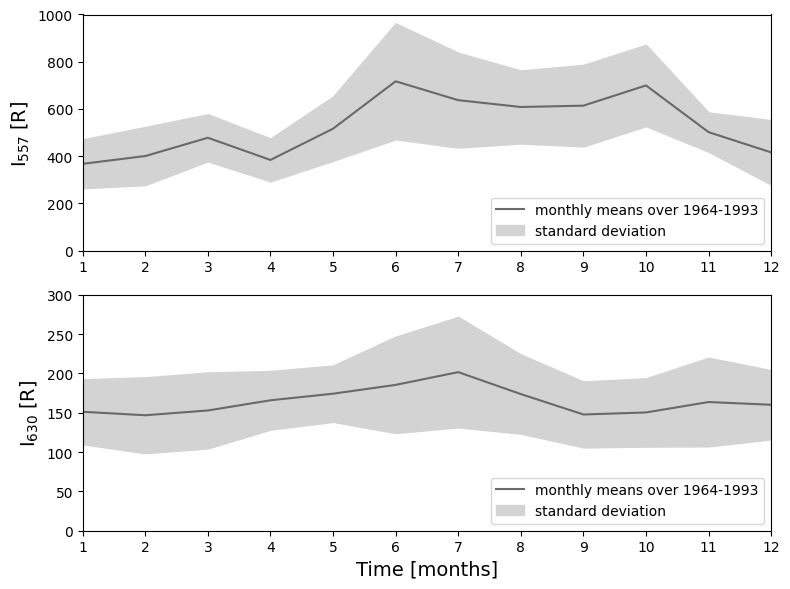

In [41]:
# The annual variation is related to change of seasons. 
# 'adf' stands for 'Annual Data Frame'

adf = pd.DataFrame()
adf['I5577'] = df_xgb.I5577_modeled_xgb
adf['I6300'] = df_xgb.I6300_modeled_xgb
adf.fillna(0, inplace=True) # NaN needs to be replaced
adfd = adf.resample('M').mean()
adfd['Year'] = adfd.index.year
adfd['Month'] = adfd.index.month
# generate pivot tables and calculate mean and standard deviation for each month over years
pivg = pd.pivot_table(adfd, index=['Month'],columns=['Year'], values=['I5577'])
pivr = pd.pivot_table(adfd, index=['Month'],columns=['Year'], values=['I6300'])
pivg['mean'] = pivg.mean(axis=1)
pivr['mean'] = pivr.mean(axis=1)
pivg['std'] = pivg.std(axis=1)
pivr['std'] = pivr.std(axis=1)
print(pivg.head(5))
print(pivr.head(5))

# plot data from pivot tables
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.ylabel('I$_{557}$ [R]', fontsize=14)
plt.xlim(pivg.index[0], pivg.index[-1])
plt.ylim(0, 1000)
plt.xticks(pivg.index)
#plt.grid(linewidth=0.1)
plt.plot(pivg.index, pivg['mean'], color='dimgray', label='monthly means over 1964-1993')
plt.fill_between(pivg.index, pivg['mean'] - pivg['std'], pivg['mean'] + pivg['std'], color='lightgray', label='standard deviation')
plt.legend(loc='lower right', fontsize=10)
plt.subplot(212)
plt.xlabel('Time [months]', fontsize=14)
plt.ylabel('I$_{630}$ [R]', fontsize=14)
plt.xlim(pivr.index[0], pivr.index[-1])
plt.ylim(0, 300)
plt.xticks(pivr.index)
#plt.grid(linewidth=0.1)
plt.plot(pivg.index, pivr['mean'], color='dimgray', label='monthly means over 1964-1993')
plt.fill_between(pivr.index, pivr['mean'] - pivr['std'], pivr['mean'] + pivr['std'], color='lightgray', label='standard deviation')
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()
#plt.savefig('figure5.eps', format='eps', dpi=600)